# Amazon Nova Multimodal Embeddings Model / OpenSearch Demonstration

Author: Gary A. Stafford

Date: 2025-10-29

License: MIT License

**Prerequisites**

See [README](READM.md) file for prerequisites.

**Workflow Diagram**

![Architecture](./previews/twelve_labs_on_bedrock_v3.png)

## Install Required Python Packages


In [27]:
%pip install pip -Uq
%pip install -r requirements.txt -Uq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Restart Kernel

If first time installing the packages, restart your Jupyter Notebook's kernel before continuing.


## Load Environment Variables

There are several ways to lo ad your sensitive environment variables. The package, `python-dotenv`, reads key-value pairs from a plain text `.env` file and can set them as environment variables. We are using the `.env` file to store our sensitive variables. 


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # Loads variables from .env file

AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN")
S3_VIDEO_STORAGE_BUCKET = os.getenv("S3_VIDEO_STORAGE_BUCKET")

OPENSEARCH_ENDPOINT = os.getenv("OPENSEARCH_ENDPOINT")

EMBEDDING_DIMENSION = int(os.getenv("EMBEDDING_DIMENSION", "1024"))

### Constants


In [ ]:
# Set the OpenSearch index name
INDEX_NAME = "tv-commercials-index-nova-mm"

# Set the local directories for OpenSearch documents
DOCUMENT_DIRECTORY = "documents"

# Set the model ID and S3 destination prefix for embeddings
MODEL_ID = "amazon.nova-2-multimodal-embeddings-v1:0"
S3_DESTINATION_PREFIX = "embeddings"

## OpenSearch


### Load Required Packages


In [3]:
import boto3
from botocore.config import Config
import json

from utilities import Utilities

from opensearchpy import (
    AWSV4SignerAuth,
    NotFoundError,
    OpenSearch,
    RequestsHttpConnection,
)

### Option #1: Amazon OpenSearch Client


In [4]:
# Create OpenSearch client for Amazon OpenSearch Serverless
# https://opensearch.org/docs/latest/clients/python-low-level/#connecting-to-amazon-opensearch-serverless

service = "aoss"
credentials = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    aws_session_token=AWS_SESSION_TOKEN,
    region_name=AWS_REGION,
).get_credentials()
auth = AWSV4SignerAuth(credentials, AWS_REGION, service)

os_client = OpenSearch(
    hosts=[{"host": OPENSEARCH_ENDPOINT, "port": 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

os_client

<OpenSearch([{'host': 'localhost', 'port': 443}])>

### Option #2: OpenSearch Client Running in Docker

Recommended for local development and debugging purposes only as an alternative to Amazon OpenSearch Serverless.


In [5]:
import warnings

# Suppress security warnings related to unverified HTTPS requests and SSL connections
warnings.filterwarnings("ignore", message="Unverified HTTPS request")
warnings.filterwarnings(
    "ignore", message="Connecting to https://localhost:9200 using SSL"
)

os_client = OpenSearch(
    hosts=[{"host": OPENSEARCH_ENDPOINT, "port": 9200}],
    http_auth=("admin", "OpenSearch123"),
    use_ssl=True,
    verify_certs=False,
)

os_client

<OpenSearch([{'host': 'localhost', 'port': 9200}])>

### Create New OpenSearch Vector Index


#### Optionally: Delete Existing Index


In [98]:
def delete_index(os_client, os_index: str) -> None:
    """Delete an index in OpenSearch.

    Args:
        os_client (OpenSearch): The OpenSearch client instance.
        os_index (str): The name of the index to delete.

    Returns:
        None
    """
    try:
        if not os_client.indices.exists(index=os_index):
            print(f"Index '{os_index}' does not exist.")
        else:
            os_client.indices.delete(index=os_index)
            print(f"Index '{os_index}' deleted successfully.")
    except ConnectionError as e:
        print(f"Connection error while deleting index '{os_index}': {e}")


# Delete the OpenSearch index for video embeddings
delete_index(os_client, INDEX_NAME)

Index 'tv-commercials-index-nova-mm-emd' deleted successfully.


#### Create New Index


In [99]:
# https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/nested-search-knn/


def create_index(os_client, os_index: str) -> None:
    """Create an index in OpenSearch with specified settings and mappings.

    Args:
        os_client (OpenSearch): The OpenSearch client instance.
        os_index (str): The name of the index to create.

    Returns:
        None
    """
    # Define the index settings and mappings
    index_body = {
        "settings": {
            "index": {
                "knn": True,
                "number_of_shards": 2,
            }
        },
        "mappings": {
            "properties": {
                "embeddings": {
                    "type": "nested",
                    "properties": {
                        "embedding": {
                            "type": "knn_vector",
                            "dimension": 1024,
                            "method": {
                                "engine": "faiss",
                                "name": "hnsw",
                                "space_type": "cosinesimil",  # Use l2 for Amazon OpenSearch Serverless
                            },
                        }
                    },
                }
            }
        },
    }

    # Check if the index already exists
    if os_client.indices.exists(index=os_index):
        print(f"Index '{os_index}' already exists.")
    else:
        os_client.indices.create(index=os_index, body=index_body)
        print(f"Index '{os_index}' created successfully.")


# Create the OpenSearch index for video embeddings
create_index(os_client, INDEX_NAME)

Index 'tv-commercials-index-nova-mm-emd' created successfully.


#### Retrieve Information About OpenSearch Index


In [100]:
try:
    response = os_client.indices.get(index=INDEX_NAME)
    print(json.dumps(response, indent=4))
except NotFoundError as ex:
    print(f"Index not found: {ex}")
except Exception as ex:
    print(ex.error)

{
    "tv-commercials-index-nova-mm-emd": {
        "aliases": {},
        "mappings": {
            "properties": {
                "embeddings": {
                    "type": "nested",
                    "properties": {
                        "embedding": {
                            "type": "knn_vector",
                            "dimension": 1024,
                            "method": {
                                "engine": "faiss",
                                "space_type": "cosinesimil",
                                "name": "hnsw",
                                "parameters": {}
                            }
                        }
                    }
                }
            }
        },
        "settings": {
            "index": {
                "replication": {
                    "type": "DOCUMENT"
                },
                "number_of_shards": "2",
                "provided_name": "tv-commercials-index-nova-mm-emd",
                "knn": "t

### Bulk Index OpenSearch Documents


In [101]:
def load_and_index_documents(os_index: str, document_path: str) -> None:
    """Load documents from JSON files in the specified directory and index them in OpenSearch.

    Args:
        os_index (str): The name of the OpenSearch index to create or use.
        document_path (str): Directory containing the document JSON files

    Returns:
        None
    """
    payload = ""
    put_command = f'{{ "create": {{ "_index": "{os_index}" }} }}\n'

    for file in os.listdir(document_path):
        if file.endswith(".json"):
            with open(os.path.join(document_path, file), "r") as f:
                tmp = json.load(f)
                payload += f"{put_command}{json.dumps(tmp)}\n"
    try:
        response = os_client.bulk(
            index=os_index,
            body=payload,
        )
        print(json.dumps(response, indent=4))
        row_count = int(len(payload.splitlines()) / 2)
        return row_count
    except Exception as ex:
        print(f"Error indexing documents: {ex}")
        return 0


if not os.path.exists(DOCUMENT_DIRECTORY):
    print(
        f"Document directory '{DOCUMENT_DIRECTORY}' does not exist, skipping indexing."
    )
else:
    row_count = load_and_index_documents(INDEX_NAME, DOCUMENT_DIRECTORY)
    print(f"Total rows to index: {row_count}")

{
    "took": 211,
    "errors": false,
    "items": [
        {
            "create": {
                "_index": "tv-commercials-index-nova-mm-emd",
                "_id": "aEnqNZoBI8d_wz4vAWX2",
                "_version": 1,
                "result": "created",
                "_shards": {
                    "total": 2,
                    "successful": 1,
                    "failed": 0
                },
                "_seq_no": 0,
                "_primary_term": 1,
                "status": 201
            }
        },
        {
            "create": {
                "_index": "tv-commercials-index-nova-mm-emd",
                "_id": "aUnqNZoBI8d_wz4vAWX2",
                "_version": 1,
                "result": "created",
                "_shards": {
                    "total": 2,
                    "successful": 1,
                    "failed": 0
                },
                "_seq_no": 0,
                "_primary_term": 1,
                "status": 201
        

In [102]:
from time import sleep

# Wait for Amazon OpenSearch Serverless indexing to complete and refresh (~60s)
response = os_client.count(index=INDEX_NAME)
while response["count"] != row_count:
    response = os_client.count(index=INDEX_NAME)
    print(f"Current indexed documents: {response['count']}")
    sleep(10)
print(f"Indexing completed. Total indexed documents: {response['count']}")

Indexing completed. Total indexed documents: 60


## Query the Amazon OpenSearch Index


### Convert User Text Query to Embedding


In [44]:
%%time


def generate_search_embedding(client: boto3.client, search_text) -> dict:
    """Generates an embedding for a search query using the Bedrock service.
    Args:
        client (boto3.client): The Boto3 client for the Bedrock service.
    Returns:
        dict: The response from the video analysis job.
    """

    # Create embedding
    request_body = {
        "taskType": "SINGLE_EMBEDDING",
        "singleEmbeddingParams": {
            "embeddingPurpose": "GENERIC_INDEX",
            "embeddingDimension": EMBEDDING_DIMENSION,
            "text": {"truncationMode": "END", "value": search_text},
        },
    }

    response = client.invoke_model(
        body=json.dumps(request_body),
        modelId=MODEL_ID,
        contentType="application/json",
    )

    return response


def download_search_embedding_from_s3(client: boto3.client, s3_key: str) -> dict:
    """Download the output file from S3 and save it locally.
    Args:
        client (boto3.client): The Boto3 S3 client.
        s3_key (str): The S3 key of the output file.
    Returns:
        VideoEmbeddings: The video embedding object.
    """
    s3_object = client.get_object(
        Bucket=S3_VIDEO_STORAGE_BUCKET,
        Key=s3_key,
    )
    embedding = json.loads(s3_object["Body"].read().decode("utf-8"))

    return embedding


# Instantiate the Boto3 clients
config = Config(
    retries={
        "max_attempts": 5,
        "mode": "standard",  # Or 'adaptive' for a more sophisticated approach
    }
)

bedrock_runtime_client = boto3.client(
    service_name="bedrock-runtime", region_name=AWS_REGION, config=config
)

s3_client = boto3.client("s3", region_name=AWS_REGION)

# Generate embeddings for the video
# search_text = "boom boom boom to the bassline"
search_text = "kids playing in a park"
response = generate_search_embedding(bedrock_runtime_client, search_text)
response_body = json.loads(response["body"].read())
text_embedding = response_body["embeddings"][0]["embedding"]
print(f"Embedding: {text_embedding[:5]}...")  # Print first 5 elements for brevity

# Optionally save the text embedding to a JSON file for later use
with open("text_embedding.json", "w") as f:
    json.dump(text_embedding, f, indent=4)

Embedding: [0.011878912, -0.020991502, -0.035474014, 0.03970486, 0.025222348]...
CPU times: total: 188 ms
Wall time: 607 ms


In [45]:
# Optional: Reload the embeddings from JSON files instead of calling the API repeatedly.
# This can be useful for offline use or debugging and testing purposes.

text_embedding = json.load(open("text_embedding.json", "r"))

### Nested k-NN Semantic Search (Approximate k-NN Search (ANN))


In [46]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/vector-search-techniques/approximate-knn/#get-started-with-approximate-k-nn


def semantic_search(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 6,
                        }
                    }
                },
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_1 = semantic_search(INDEX_NAME, text_embedding)

for hit in search_results_1["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds

Video ID: nike_dream_crazier_justdoit.mp4
Title: Empowering Moments: A Tribute to Female Athletes
Score: 0.57800573
Duration: 90.00 seconds

Video ID: what_if_you_can_nike.mp4
Title: A Day in the Life of a Teenage Girl
Score: 0.5681261
Duration: 90.00 seconds

Video ID: sling_baby_doritos_commercial_superbowl_commercials.mp4
Title: A Day of Laughter and Play
Score: 0.5664107
Duration: 24.00 seconds

Video ID: lunchables_commercial_2025.mp4
Title: Lunchables: A School Lunch Adventure
Score: 0.5572287
Duration: 16.00 seconds

Video ID: skipped_exits_the_new_2025_aviator_suv_lincoln.mp4
Title: Lincoln Aviator: A Journey of Luxury and Adventure
Score: 0.55631894
Duration: 30.00 seconds



### Nested k-NN Semantic Search with Filters


In [47]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/filter-search-knn/efficient-knn-filtering/


def semantic_search_with_filter(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with a filter on segment duration.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 6,
                            "filter": {
                                "bool": {
                                    "must": [
                                        {
                                            "range": {
                                                "durationSec": {
                                                    "gte": 20,
                                                    "lte": 60,
                                                }
                                            }
                                        },
                                    ]
                                }
                            },
                        }
                    }
                },
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_2 = semantic_search_with_filter(INDEX_NAME, text_embedding)

for hit in search_results_2["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds

Video ID: sling_baby_doritos_commercial_superbowl_commercials.mp4
Title: A Day of Laughter and Play
Score: 0.5664107
Duration: 24.00 seconds

Video ID: skipped_exits_the_new_2025_aviator_suv_lincoln.mp4
Title: Lincoln Aviator: A Journey of Luxury and Adventure
Score: 0.55631894
Duration: 30.00 seconds

Video ID: disney_resorts_collection_stay_longer_save_more_june_2025.mp4
Title: Magical Moments at Disney Resorts
Score: 0.5488633
Duration: 30.00 seconds

Video ID: temu_s_big_game_ad_encore_tv_commercial_2024.mp4
Title: TEMU: Shop Like a Billionaire
Score: 0.54579014
Duration: 30.00 seconds

Video ID: trivago_commercial_muskoka_pines_hotel_2025.mp4
Title: Trivago: Finding the Best Hotel Deals
Score: 0.537459
Duration: 30.00 seconds



### Nested k-NN Semantic Search with Inner Hits

Include information about the matching nested fields in the response.


In [48]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/nested-search-knn/#inner-hits


def semantic_search_inner_hits(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with inner hits to retrieve nested segments.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 6,
                        }
                    }
                },
                "inner_hits": {
                    "_source": False,
                    "fields": [
                        "embeddings.startSec",
                        "embeddings.endSec",
                        "embeddings.embeddingOption",
                    ],
                },
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_3 = semantic_search_inner_hits(INDEX_NAME, text_embedding)
# print(search_results_3)
for hit in search_results_3["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("Matching Segment:")
    for segment in hit["inner_hits"]["embeddings"]["hits"]["hits"]:
        print(f"  Segment: {segment['_nested']['offset']}")
        print(f"    Score: {segment['_score']}")
        print(
            f"    Start: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentStartSeconds']} seconds"
        )
        print(
            f"    End: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentEndSeconds']} seconds"
        )
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds
Matching Segment:
  Segment: 7
    Score: 0.5805131
    Start: 42.0 seconds
    End: 46.0 seconds

Video ID: nike_dream_crazier_justdoit.mp4
Title: Empowering Moments: A Tribute to Female Athletes
Score: 0.57800573
Duration: 90.00 seconds
Matching Segment:
  Segment: 2
    Score: 0.57800573
    Start: 12.0 seconds
    End: 18.0 seconds

Video ID: what_if_you_can_nike.mp4
Title: A Day in the Life of a Teenage Girl
Score: 0.5681261
Duration: 90.00 seconds
Matching Segment:
  Segment: 0
    Score: 0.5681261
    Start: 0.0 seconds
    End: 6.0 seconds

Video ID: sling_baby_doritos_commercial_superbowl_commercials.mp4
Title: A Day of Laughter and Play
Score: 0.5664107
Duration: 24.00 seconds
Matching Segment:
  Segment: 1
    Score: 0.5664107
    Start: 12.0 seconds
    End: 18.0 seconds

Video ID: lunchables_commercial_2025.mp4
Title: Lunchables: A School Lunch Adve

### Nested k-NN Semantic Search with all Nested Hits

To retrieve the scores for all nested field documents within each parent document. By default, only the highest-scoring nested document is considered when you query nested fields.

_Note that as of 2025-06-28, although Amazon OpenSearch Serverless claims that it supports version 2.19, the `expand_nested_docs` is not available (error: `Error querying index: RequestError(400, 'x_content_parse_exception', '[1:12885] [knn] unknown field [expand_nested_docs]')`). The below search was performed in OpenSearch using Docker._


In [49]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/nested-search-knn/#retrieving-all-nested-hits


def semantic_search_all_inner_hits(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with inner hits to retrieve all matching nested segments.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 6,
                            "expand_nested_docs": True,
                            "rescore": True,
                        }
                    }
                },
                "inner_hits": {
                    "_source": False,
                    "fields": [
                        "embeddings.startSec",
                        "embeddings.endSec",
                        "embeddings.embeddingOption",
                    ],
                    "size": 3,
                },
                "score_mode": "max",
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_4 = semantic_search_all_inner_hits(INDEX_NAME, text_embedding)
for hit in search_results_4["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("Matching Segments:")
    for segment in hit["inner_hits"]["embeddings"]["hits"]["hits"]:
        print(f"  Segment: {segment['_nested']['offset']}")
        print(f"    Score: {segment['_score']}")
        print(
            f"    Start: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentStartSeconds']} seconds"
        )
        print(
            f"    End: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentEndSeconds']} seconds"
        )
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds
Matching Segments:
  Segment: 7
    Score: 0.5805131
    Start: 42.0 seconds
    End: 46.0 seconds
  Segment: 1
    Score: 0.5526075
    Start: 30.0 seconds
    End: 36.0 seconds
  Segment: 6
    Score: 0.550611
    Start: 36.0 seconds
    End: 42.0 seconds

Video ID: nike_dream_crazier_justdoit.mp4
Title: Empowering Moments: A Tribute to Female Athletes
Score: 0.57800573
Duration: 90.00 seconds
Matching Segments:
  Segment: 2
    Score: 0.57800573
    Start: 12.0 seconds
    End: 18.0 seconds
  Segment: 11
    Score: 0.5378354
    Start: 90.0 seconds
    End: 91.0 seconds
  Segment: 9
    Score: 0.5347862
    Start: 60.0 seconds
    End: 66.0 seconds

Video ID: what_if_you_can_nike.mp4
Title: A Day in the Life of a Teenage Girl
Score: 0.56812614
Duration: 90.00 seconds
Matching Segments:
  Segment: 0
    Score: 0.56812614
    Start: 0.0 seconds
    End: 6.0 sec

### Nested k-NN Semantic Search with all Nested Hits, with Filtering on Nested Fields


In [50]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/nested-search-knn/#retrieving-all-nested-hits


def semantic_search_all_inner_hits(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with inner hits to retrieve all matching nested segments.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 6,
                            "expand_nested_docs": True,
                            "filter": {
                                "term": {"embeddings.segmentMetadata.segmentIndex": 15}
                            },
                            "rescore": True,
                        }
                    }
                },
                "inner_hits": {
                    "_source": False,
                    "fields": [
                        "embeddings.segmentMetadata.segmentStartSeconds",
                        "embeddings.segmentMetadata.segmentEndSeconds",
                    ],
                },
                "score_mode": "max",
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_5 = semantic_search_all_inner_hits(INDEX_NAME, text_embedding)
print(search_results_5)
for hit in search_results_5["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("Matching Segments:")
    for segment in hit["inner_hits"]["embeddings"]["hits"]["hits"]:
        print(f"  Segment: {segment['_nested']['offset']}")
        print(f"    Score: {segment['_score']}")
        print(
            f"    Start: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentStartSeconds']} seconds"
        )
        print(
            f"    End: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentEndSeconds']} seconds"
        )
    print("\r")

{'took': 6, 'timed_out': False, '_shards': {'total': 2, 'successful': 2, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 8, 'relation': 'eq'}, 'max_score': 0.5378354, 'hits': [{'_index': 'tv-commercials-index-nova-mm-emd', '_id': 'iUnqNZoBI8d_wz4vAWX2', '_score': 0.5378354, '_source': {'summary': 'The video opens with a close-up of a female cyclist wiping away tears, highlighting emotional intensity. It then transitions to a young girl in a football uniform running onto the field and tackling a player in a maroon uniform, showcasing determination and physical prowess. A group of female soccer players, with a young girl in front, stand with their hands over their hearts, emphasizing unity and pride. A blonde woman in a red shirt and a female tennis player in a white outfit are shown, with the latter preparing to serve, indicating a range of sports participation. A basketball player in a yellow uniform argues with a referee, her face close to the camera, illustrating confrontatio

### Radial Search

Search all points within a vector space that reside within a specified maximum distance or minimum score threshold from a query point (squared Euclidean distance).


In [51]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/radial-search-knn/


def radial_search(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with radial search to find segments within a certain distance.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "max_distance": 1,
                        }
                    }
                },
            }
        },
        "size": 6,
        "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_6 = semantic_search(INDEX_NAME, text_embedding)

for hit in search_results_6["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds

Video ID: nike_dream_crazier_justdoit.mp4
Title: Empowering Moments: A Tribute to Female Athletes
Score: 0.57800573
Duration: 90.00 seconds

Video ID: what_if_you_can_nike.mp4
Title: A Day in the Life of a Teenage Girl
Score: 0.5681261
Duration: 90.00 seconds

Video ID: sling_baby_doritos_commercial_superbowl_commercials.mp4
Title: A Day of Laughter and Play
Score: 0.5664107
Duration: 24.00 seconds

Video ID: lunchables_commercial_2025.mp4
Title: Lunchables: A School Lunch Adventure
Score: 0.5572287
Duration: 16.00 seconds

Video ID: skipped_exits_the_new_2025_aviator_suv_lincoln.mp4
Title: Lincoln Aviator: A Journey of Luxury and Adventure
Score: 0.55631894
Duration: 30.00 seconds



## Displaying Previews of Search Results


### Visual Grid of Results


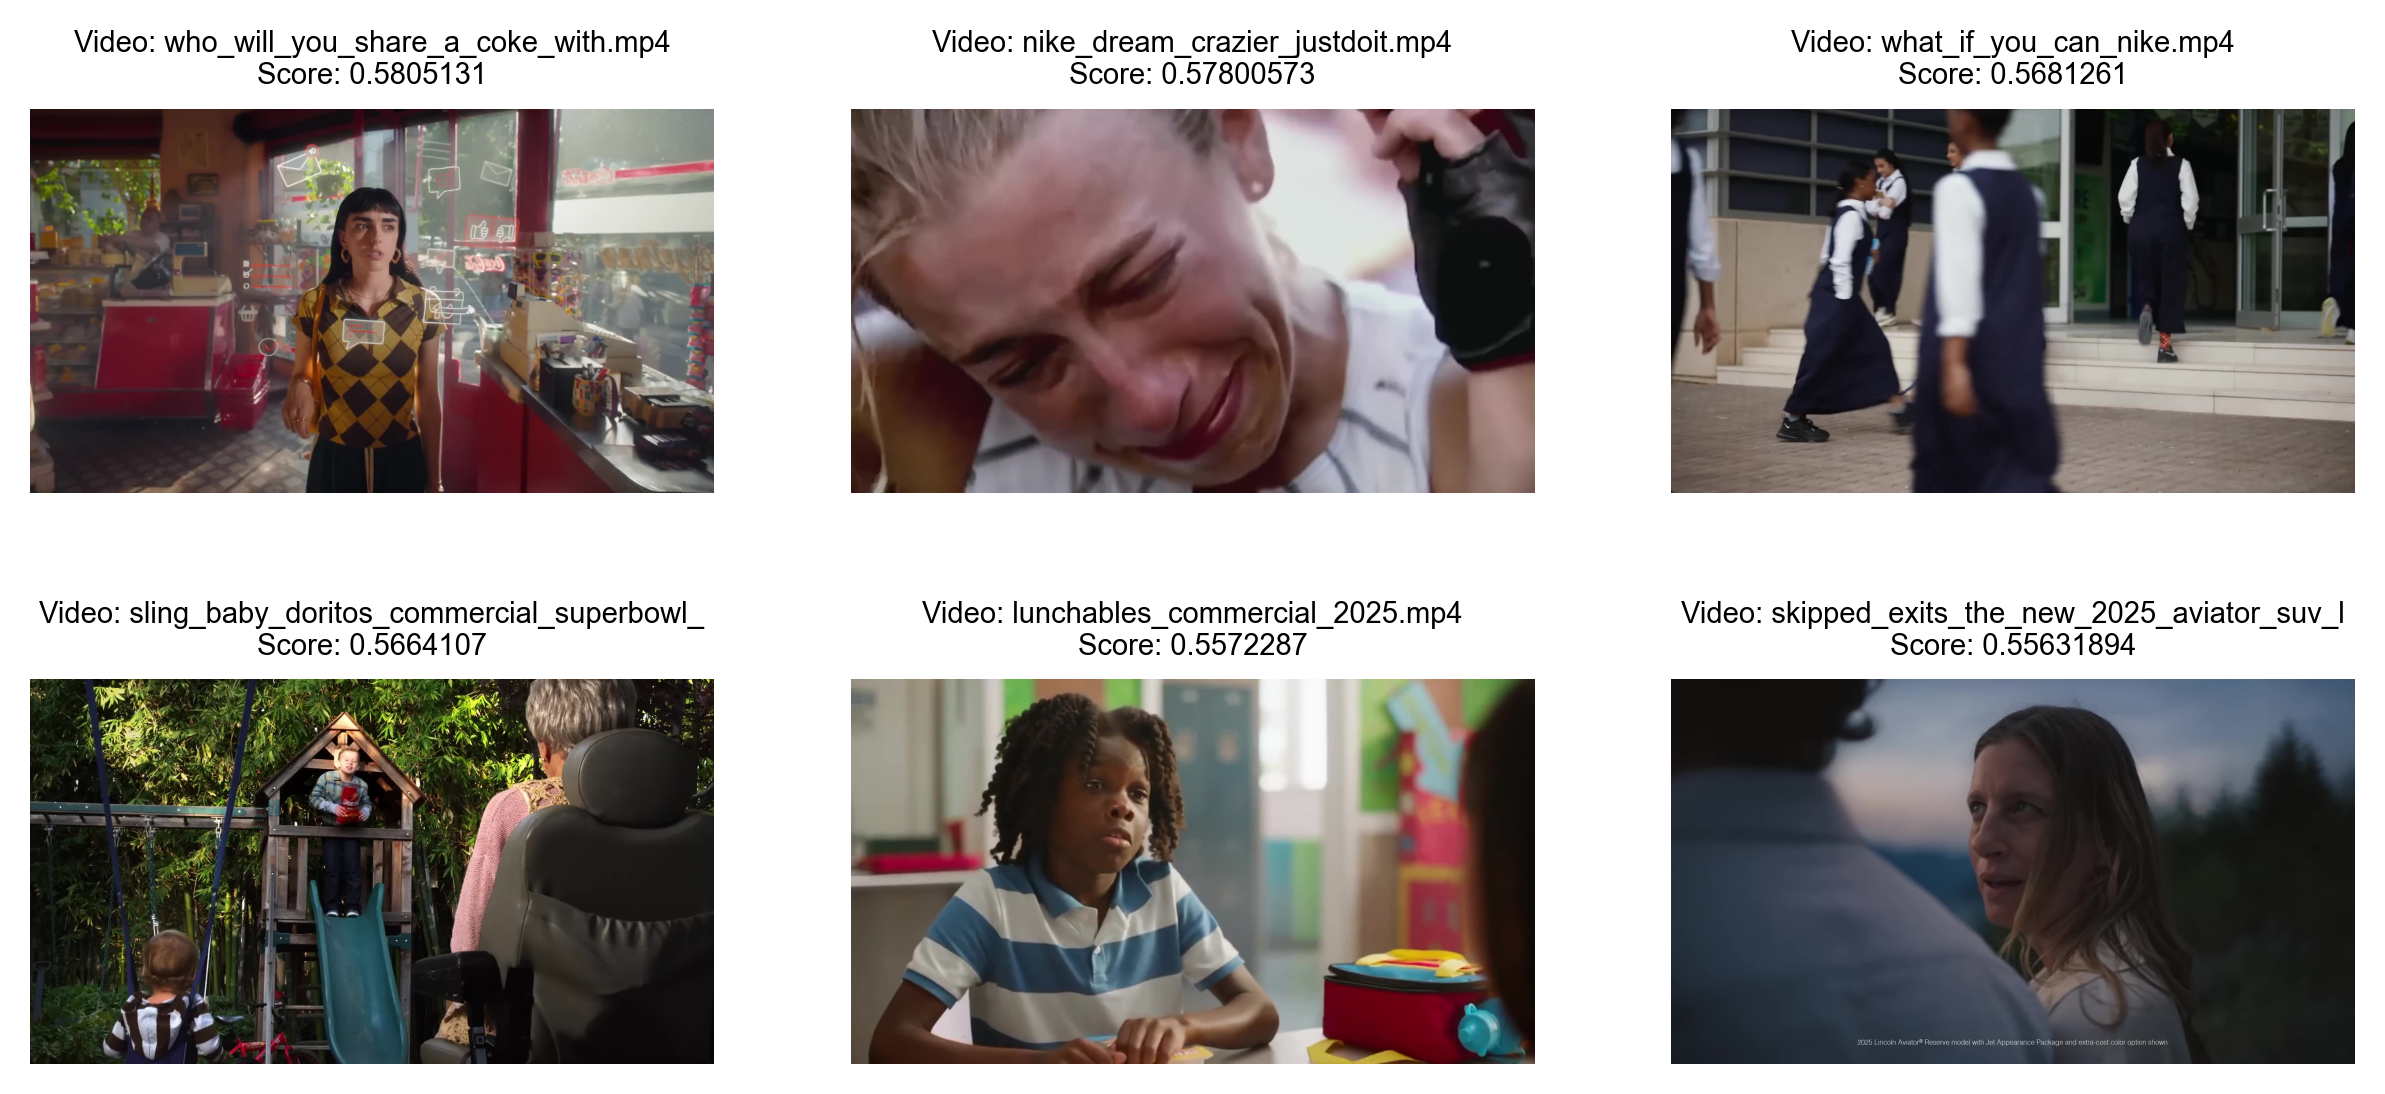

In [52]:
from matplotlib import pyplot as plt
from PIL import Image
from urllib import request
import io


def load_image_from_url(url: str) -> Image.Image:
    """Load an image from a URL.

    Args:
        url (str): The URL of the image to load.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    try:
        with request.urlopen(url) as response:
            image_data = response.read()
            image = Image.open(io.BytesIO(image_data))
            return image
    except Exception as e:
        print(f"Error loading video thumbnail from URL: {e}")
        return None


index = 1
rows = 3
columns = 3

fig = plt.figure(figsize=(10, 7))

for hit in search_results_1["hits"]["hits"]:
    fig.set_dpi(300)
    fig.add_subplot(rows, columns, index)
    image_url = hit["_source"]["keyframeURL"]
    image = load_image_from_url(image_url)
    plt.axis("off")
    plt.imshow(image)
    plt.title(
        f'Video: {hit["_source"]["videoName"][0:40]}\nScore: {hit["_score"]}',
        fontdict=dict(family="Arial", size=7),
        color="black",
    )
    index += 1

### 2D/3D Visualizations Using t-SNE

t-SNE (t-distributed Stochastic Neighbor Embedding) is a popular technique for reducing high-dimensional data, such as embeddings, to 2 or 3 dimensions for visualization or further analysis.


In [53]:
def semantic_search_t_sne(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch including embeddings.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 9,
                        }
                    }
                },
                "inner_hits": {
                    "_source": False,
                    "fields": [
                        "embeddings.segmentMetadata.segmentStartSeconds",
                        "embeddings.segmentMetadata.segmentEndSeconds",
                    ],
                },
            }
        },
        "size": 9,
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_7 = semantic_search_t_sne(INDEX_NAME, text_embedding)

In [54]:
# Extract embeddings and video names from the search results
results = []

for hit in search_results_7["hits"]["hits"]:
    results.append(
        [
            hit["_source"]["embeddings"][0]["embedding"],
            hit["_source"]["videoName"],
        ]
    )

results.append([text_embedding, "User query"])
print(len(results))

10


#### 2D Visualization Using t-SNE


In [55]:
from sklearn.manifold import TSNE
import numpy as np

# Initialize t-SNE (n_components=2 for 2D reduction)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)

# Extract embeddings and apply t-SNE
embeddings = np.array([res[0] for res in results])
embeddings = tsne.fit_transform(embeddings)

# Combine the reduced embeddings with their corresponding video names
vis_dims_2d_tsne = list(
    map(
        lambda x: [x[0][0], x[0][1], x[1]], zip(embeddings, [res[1] for res in results])
    )
)
print(vis_dims_2d_tsne[0])

[np.float32(-28.273727), np.float32(-71.90101), 'who_will_you_share_a_coke_with.mp4']


In [56]:
import plotly.graph_objs as go

fig = go.Figure()

# Search results
for i, video_name in enumerate(vis_dims_2d_tsne[0:-1]):
    x = np.array([vis_dims_2d_tsne[i][0]])
    y = np.array([vis_dims_2d_tsne[i][1]])
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode="markers",
            marker=dict(
                size=15,
                colorscale="Viridis",
                opacity=1.0,
                symbol="circle",
            ),
            name=vis_dims_2d_tsne[i][2][0:25],
        )
    )

    # User query
    x = np.array([vis_dims_2d_tsne[-1][0]])
    y = np.array([vis_dims_2d_tsne[-1][1]])

fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode="text+markers",
        marker=dict(
            size=15,
            color="black",
            colorscale="Viridis",
            opacity=1.0,
            symbol="square",
        ),
        name=vis_dims_2d_tsne[-1][2][0:25],
        text=vis_dims_2d_tsne[-1][2],
        textposition="bottom center",
        showlegend=False,
    )
)

fig.update_layout(
    autosize=True,
    width=900,
    height=600,
    font=dict(size=12, color="black", family="Arial, sans-serif"),
    title="Search Results using t-SNE",
    margin=dict(l=30, r=30, b=30, t=60, pad=10),
    xaxis=dict(title="x"),
    yaxis=dict(title="y"),
    legend=dict(title="   Search Results"),
)
fig.show()

#### 3D Visualization Using t-SNE


In [57]:
from sklearn.manifold import TSNE
import numpy as np

# Initialize t-SNE (n_components=3 for 3D reduction)
tsne = TSNE(n_components=3, random_state=42, perplexity=5)

# Extract embeddings and apply t-SNE
embeddings = np.array([res[0] for res in results])
embeddings = tsne.fit_transform(embeddings)

# Combine the reduced embeddings with their corresponding video names
vis_dims_3d_tsne = list(
    map(
        lambda x: [x[0][0], x[0][1], x[0][2], x[1]],
        zip(embeddings, [res[1] for res in results]),
    )
)
print(vis_dims_3d_tsne[0])

[np.float32(-3.205587), np.float32(83.215744), np.float32(102.106476), 'who_will_you_share_a_coke_with.mp4']


In [58]:
import plotly.graph_objs as go

fig = go.Figure()

# Results
for i, video_name in enumerate(vis_dims_3d_tsne[0:-1]):
    x = np.array([vis_dims_3d_tsne[i][0]])
    y = np.array([vis_dims_3d_tsne[i][1]])
    z = np.array([vis_dims_3d_tsne[i][2]])

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=dict(size=7, colorscale="Viridis", opacity=1.0, symbol="circle"),
            name=vis_dims_3d_tsne[i][3][0:25],
            text=vis_dims_3d_tsne[i][3][0:25],
            textposition="top center",
        )
    )

    # User query
    x = np.array([vis_dims_3d_tsne[-1][0]])
    y = np.array([vis_dims_3d_tsne[-1][1]])
    z = np.array([vis_dims_3d_tsne[-1][2]])

fig.add_trace(
    go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode="markers",
        marker=dict(
            size=7, color="black", colorscale="Viridis", opacity=1.0, symbol="square"
        ),
        name=vis_dims_3d_tsne[-1][3],
        text=vis_dims_3d_tsne[-1][3],
        textposition="top center",
        showlegend=False,
    )
)

x_eye = -1.25
y_eye = 1.5
z_eye = 0.5

fig.update_layout(
    # autosize=True,
    width=900,
    height=600,
    font=dict(size=12, color="black", family="Arial, sans-serif"),
    title="Search Results using t-SNE",
    margin=dict(l=30, r=30, b=30, t=50, pad=10),
    scene=dict(
        xaxis=dict(title="z"),
        yaxis=dict(title="x"),
        zaxis=dict(title="y"),
    ),
    scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
    updatemenus=[
        dict(
            type="buttons",
            showactive=True,
            y=0.9,
            x=0.9,
            xanchor="left",
            yanchor="bottom",
            pad=dict(t=10, r=10),
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=15, redraw=True),
                            transition=dict(duration=1),
                            fromcurrent=True,
                            mode="immediate",
                        ),
                    ],
                )
            ],
        )
    ],
    legend=dict(
        title="   Search Results",
    ),
)


def rotate_z(x, y, z, theta):
    w = x + 1j * y
    return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z


frames = []
for t in np.arange(0, 10, 0.01):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames = frames

fig.show()

### Extracting a List of Segments from Video Search Results

Reorder the search results as a list of segments as opposed to a list of videos.


In [59]:
# Reference: https://docs.opensearch.org/docs/latest/vector-search/specialized-operations/nested-search-knn/#retrieving-all-nested-hits


def semantic_search_all_inner_hits(os_index: str, embedding: list) -> dict:
    """Query the OpenSearch index using a text embedding with inner hits to retrieve all matching nested segments.

    Args:
        os_index (str): The ID of the Amazon OpenSearch index.
        embedding (list): The embedding vector to use for the query.

    Returns:
        dict: The search response from OpenSearch.
    """
    query = {
        "query": {
            "nested": {
                "path": "embeddings",
                "query": {
                    "knn": {
                        "embeddings.embedding": {
                            "vector": embedding,
                            "k": 50,
                            "expand_nested_docs": True,
                            "rescore": True,
                        }
                    }
                },
                "inner_hits": {
                    "_source": False,
                    "fields": [
                        "embeddings.segmentMetadata.segmentStartSeconds",
                        "embeddings.segmentMetadata.segmentEndSeconds",
                        "embeddings.embedding",
                    ],
                    "size": 100,
                },
                "score_mode": "max",
            }
        },
        "size": 50,
        # "_source": {"excludes": ["embeddings.embedding"]},
    }

    try:
        search_results = os_client.search(body=query, index=os_index)
        return search_results
    except Exception as ex:
        print(f"Error querying index: {ex}")
        return {}


# Query the index with the embedding
search_results_8 = semantic_search_all_inner_hits(INDEX_NAME, text_embedding)

for hit in search_results_8["hits"]["hits"]:
    print(f"Video ID: {hit['_source']['videoName']}")
    print(f"Title: {hit['_source']['title']}")
    print(f"Score: {hit['_score']}")
    print(f"Duration: {hit['_source']['durationSec']:.2f} seconds")
    print("Matching Segments:")
    for segment in hit["inner_hits"]["embeddings"]["hits"]["hits"]:
        print(f"  Segment: {segment['_nested']['offset']}")
        print(f"    Score: {segment['_score']}")
        print(
            f"    Start: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentStartSeconds']} seconds"
        )
        print(
            f"    End: {hit['_source']['embeddings'][segment['_nested']['offset']]['segmentMetadata']['segmentEndSeconds']} seconds"
        )
    print("\r")

Video ID: who_will_you_share_a_coke_with.mp4
Title: Coke Connection: Sharing Moments
Score: 0.5805131
Duration: 46.00 seconds
Matching Segments:
  Segment: 7
    Score: 0.5805131
    Start: 42.0 seconds
    End: 46.0 seconds
  Segment: 1
    Score: 0.5526075
    Start: 30.0 seconds
    End: 36.0 seconds
  Segment: 6
    Score: 0.550611
    Start: 36.0 seconds
    End: 42.0 seconds
  Segment: 0
    Score: 0.4853344
    Start: 6.0 seconds
    End: 12.0 seconds
  Segment: 5
    Score: 0.47361138
    Start: 24.0 seconds
    End: 30.0 seconds
  Segment: 2
    Score: 0.46973538
    Start: 0.0 seconds
    End: 6.0 seconds
  Segment: 4
    Score: 0.44715878
    Start: 12.0 seconds
    End: 18.0 seconds
  Segment: 3
    Score: 0.4366768
    Start: 18.0 seconds
    End: 24.0 seconds

Video ID: nike_dream_crazier_justdoit.mp4
Title: Empowering Moments: A Tribute to Female Athletes
Score: 0.57800573
Duration: 90.00 seconds
Matching Segments:
  Segment: 2
    Score: 0.57800573
    Start: 12.0 secon

In [60]:
def extract_segments_sorted_by_score(results: dict) -> list:
    """Extract segments from search results and sort them by score.

    Args:
        results (dict): The search results from the OpenSearch query.

    Returns:
        list: A list of segments sorted by their score in descending order.
    """
    segments = []

    for hit in results["hits"]["hits"]:
        for segment in hit["inner_hits"]["embeddings"]["hits"]["hits"]:
            segment_score = {}
            segment_score["title"] = hit["_source"]["title"]
            segment_score["videoName"] = hit["_source"]["videoName"]
            segment_score["offset"] = segment["_nested"]["offset"]
            segment_score["_score"] = segment["_score"]
            # segment_score["embedding_option"] = segment["fields"][
            #     "embeddings.embeddingOption"
            # ][0]
            segment_score["startSec"] = round(
                segment["fields"]["embeddings.segmentMetadata.segmentStartSeconds"][0],
                2,
            )
            segment_score["endSec"] = round(
                segment["fields"]["embeddings.segmentMetadata.segmentEndSeconds"][0], 2
            )
            segment_score["embedding"] = segment["fields"]["embeddings.embedding"]
            segments.append(segment_score)

    segments = sorted(segments, key=lambda x: x["_score"], reverse=True)
    # print(json.dumps(segments[:3], indent=4))
    return segments

#### Display Top Video Segment from Search Results


In [61]:
from IPython.display import HTML

segments = extract_segments_sorted_by_score(search_results_8)
video_file = segments[0]["videoName"]
segment_start = segments[0]["startSec"]
segment_end = segments[0]["endSec"]

HTML(
    f"""
    <h2>Segment Details</h2>
    <p>User query: "{search_text}"</p>
    <p>Filename: {video_file}</p>
    <p>Segment start: {segment_start} seconds</p>
    <p>Segment end: {segment_end} seconds</p>
    <video width="600" height="auto" controls>
        <source src="videos//{video_file}#t={segment_start},{segment_end}" type="video/mp4">
    </video>    
"""
)

#### Display All Segments in 2D Scatter Plot Using PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique used to simplify complex datasets by transforming the original variables into a new set of uncorrelated variables called principal components.


In [62]:
from sklearn.decomposition import PCA

# Extract segments and their embeddings from the search results
segments = extract_segments_sorted_by_score(search_results_8)
embeddings = list(map(lambda segment: segment["embedding"], segments))

# Reduce the dense vector embedding's dimensions from 1,024 to 2 using PCA for visualization
pca = PCA(n_components=2)

# Fit the PCA model to the embeddings and transform them to 2D
vis_dims_2d_pca = pca.fit_transform(embeddings)
print(f"Reduced dimensions shape (2d): {vis_dims_2d_pca.shape}")

Reduced dimensions shape (2d): (471, 2)


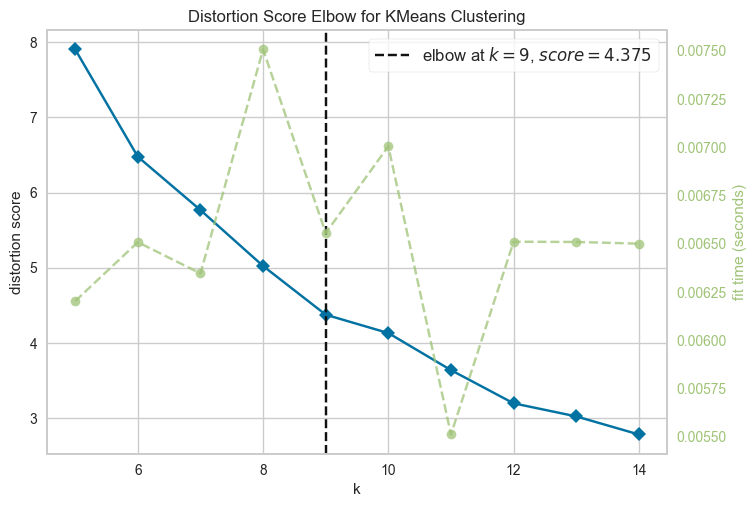

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Adjust the range as needed
MIN_CLUSTERS = 5
MAX_CLUSTERS = 15


# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(MIN_CLUSTERS, MAX_CLUSTERS))

visualizer.fit(vis_dims_2d_pca)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [67]:
import plotly.express as px

# Find clusters using KMeans
kmeans = KMeans(n_clusters=9, random_state=0).fit(vis_dims_2d_pca)
labels = kmeans.labels_

# Create a new list of segments with the 2D embeddings
segments = list(
    map(
        lambda segment, vis_dim: {**segment, "embedding": vis_dim},
        segments,
        vis_dims_2d_pca,
    )
)

fig = px.scatter(
    segments,
    x=[segment["embedding"][0] for segment in segments],
    y=[segment["embedding"][1] for segment in segments],
    color=[segment["videoName"] for segment in segments],
    hover_name=[segment["videoName"] for segment in segments],
    hover_data=["startSec", "endSec", "offset"],
    title="All Commercial Segments using PCA",
    labels={"x": "PCA Dimension 1", "y": "PCA Dimension 2"},
    width=900,
    height=600,
    opacity=0.75,
)

fig.layout.xaxis.scaleanchor = "y"
fig.layout.yaxis.scaleanchor = "x"
fig.layout.xaxis.scaleratio = 1
fig.layout.yaxis.scaleratio = 1
fig.layout.xaxis.dtick = 0.25
fig.layout.yaxis.dtick = 0.25
fig.layout.legend = dict(
    title_text="Embedding Type",
    font=dict(size=10, family="Arial, sans-serif"),
)
fig.layout.title.font = dict(
    size=16,
    family="Arial, sans-serif",
)
fig.layout.showlegend = False

# Add circles around clusters
for cluster in np.unique(labels):
    cluster_points = vis_dims_2d_pca[labels == cluster]
    center = cluster_points.mean(axis=0)
    radius = np.linalg.norm(cluster_points - center, axis=1).max()
    # Define circle bounds (Plotly circles use bounding box)
    x0, y0 = center - radius
    x1, y1 = center + radius
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=x0,
        y0=y0,
        x1=x1,
        y1=y1,
        opacity=0.3,
        line=dict(
            color="black",
            width=1,
            dash="dot",  # Optional: change to "solid", "dash", etc. for different styles
        ),
        fillcolor="rgba(0,0,0,0)",
    )

fig.show()

#### Display All Segments in 2D Scatter Plot Using t-SNE and k-means clustering

t-SNE (t-distributed Stochastic Neighbor Embedding) is a popular technique for reducing high-dimensional data, such as embeddings, to 2 or 3 dimensions for visualization or further analysis.

k-means clustering is a popular clustering algorithm that does a good job of grouping spherical data together into distinct groups.


In [65]:
from sklearn.manifold import TSNE
import numpy as np

# Extract segments and their embeddings from the search results
segments = extract_segments_sorted_by_score(search_results_8)
embeddings = list(map(lambda segment: segment["embedding"], segments))
embeddings = np.array(embeddings)

# Initialize t-SNE (n_components=2 for 2D reduction)
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the embeddings
vis_dims_2d_tsne = tsne.fit_transform(embeddings)

print(f"Reduced dimensions shape (2d): {vis_dims_2d_tsne.shape}")

Reduced dimensions shape (2d): (471, 2)


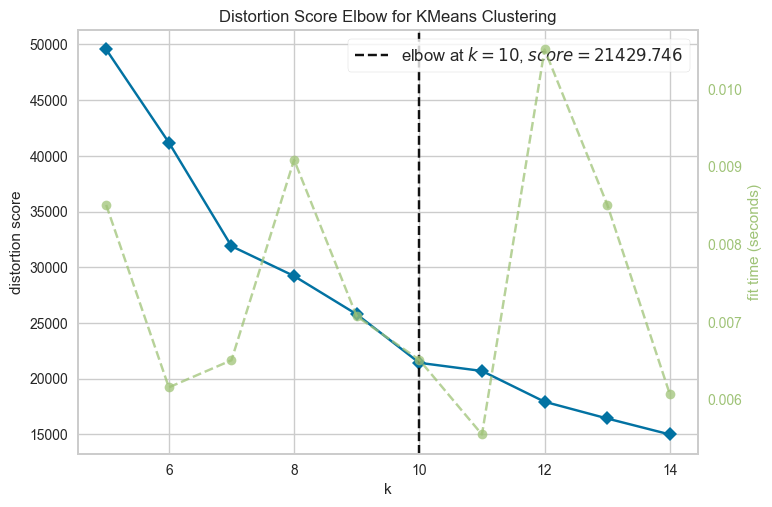

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Adjust the range as needed
MIN_CLUSTERS = 5
MAX_CLUSTERS = 15


# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(MIN_CLUSTERS, MAX_CLUSTERS))

visualizer.fit(vis_dims_2d_tsne)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [68]:
import plotly.express as px

# Find clusters using KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(vis_dims_2d_tsne)
labels = kmeans.labels_

# Create a new list of segments with the 2D embeddings
segments = list(
    map(
        lambda segment, vis_dim: {**segment, "embedding": vis_dim},
        segments,
        vis_dims_2d_tsne,
    )
)

fig = px.scatter(
    segments,
    x=[segment["embedding"][0] for segment in segments],
    y=[segment["embedding"][1] for segment in segments],
    color=[segment["videoName"][0:10] for segment in segments],
    hover_name=[segment["videoName"] for segment in segments],
    hover_data=["startSec", "endSec", "offset"],
    title="All Commercial Segments using t-SNE",
    labels={"x": "t-SNE Dimension 1", "y": "t-SNE Dimension 2"},
    width=900,
    height=600,
    opacity=0.75,
)

fig.layout.xaxis.scaleanchor = "y"
fig.layout.yaxis.scaleanchor = "x"
fig.layout.xaxis.scaleratio = 1
fig.layout.yaxis.scaleratio = 1
fig.layout.xaxis.dtick = 5
fig.layout.yaxis.dtick = 5
fig.layout.legend = dict(
    title_text="Commercial",
    font=dict(size=10, family="Arial, sans-serif"),
)
fig.layout.title.font = dict(
    size=16,
    family="Arial, sans-serif",
)
fig.layout.showlegend = False


# Add circles around clusters
for cluster in np.unique(labels):
    cluster_points = vis_dims_2d_tsne[labels == cluster]
    center = cluster_points.mean(axis=0)
    radius = np.linalg.norm(cluster_points - center, axis=1).max()
    # Define circle bounds (Plotly circles use bounding box)
    x0, y0 = center - radius
    x1, y1 = center + radius
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=x0,
        y0=y0,
        x1=x1,
        y1=y1,
        opacity=0.3,
        line=dict(
            color="black",
            width=1,
            dash="dot",  # Optional: change to "solid", "dash", etc. for different styles
        ),
        fillcolor="rgba(0,0,0,0)",
    )

fig.show()